# Text Classification of Movie Reviews (Keras & TensorFlow Hub)

This text classification example:
* trains a simple neural network on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis. 
* uses verta's Python client logging observations and artifacts


This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

The tutorial demonstrates the basic application of transfer learning with TensorFlow Hub and Keras.

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning.

## Set Up Environment

This notebook has been tested with the following package versions:  
(you may need to change `pip` to `pip3`, depending on your own Python environment)

In [ ]:
# Python 3.6
!pip install verta
!pip install matplotlib==3.1.1
# for macos
# !pip install tensorflow-macos==2.11.0
# !pip install -U tensorflow-hub==0.12.0
# else
!pip install tensorflow==2.0.0-beta1
!pip install -U tensorflow-hub==0.5.0
!pip install tensorflow-datasets==1.0.2

## Set Up Verta

In [ ]:
from verta import Client
from verta.utils import ModelAPI

# Use local env vars or uncomment and fill out the lines below:
# os.environ['VERTA_EMAIL'] = ''
# os.environ['VERTA_DEV_KEY'] = ''
# os.environ['VERTA_HOST'] = ''

client: Client = Client()

# Naming convention to be used for this example
NAME: str = 'tfhub-text-classification-example'

EXPERIMENT_NAME: str = 'gnews-swivel-20dim-clf'

proj = client.set_project(NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run()

---

## Imports

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import six

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine:

In [3]:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, validation_data), test_data = tfds.load(
    name="imdb_reviews", 
    split=(train_validation_split, tfds.Split.TEST),
    as_supervised=True)

## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label.Let's print first 10 examples.

In [4]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(2)))
train_examples_batch

2023-03-29 16:44:14.277882: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\xc3\xa9, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by 

Let's also print the first 2 labels.

In [5]:
train_labels_batch

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>

## Build the model
In this example, the input data consists of sentences. The labels to predict are either 0 or 1.
One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, we don't have to worry about text preprocessing.

For this example we will use a **pre-trained text embedding model** from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1).

In [6]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 3.9819887 , -4.4838037 ,  5.177359  , -2.3643482 , -3.2938678 ,
        -3.5364532 , -2.4786978 ,  2.5525482 ,  6.688532  , -2.3076782 ,
        -1.9807833 ,  1.1315885 , -3.0339816 , -0.7604128 , -5.743445  ,
         3.4242578 ,  4.790099  , -4.03061   , -5.992149  , -1.7297493 ],
       [ 3.4232912 , -4.230874  ,  4.1488533 , -0.29553518, -6.802391  ,
        -2.5163853 , -4.4002395 ,  1.905792  ,  4.7512794 , -0.40538004,
        -4.3401685 ,  1.0361497 ,  0.9744097 ,  0.71507156, -6.2657013 ,
         0.16533905,  4.560262  , -1.3106939 , -3.1121316 , -2.1338716 ]],
      dtype=float32)>

Let's now build the full model:

In [7]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that we are using ([google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

Let's compile the model.

In [8]:
hyperparams = {'optimizer':'adam',
               'loss':'binary_crossentropy',
               'metrics':'accuracy', 
               'train_batch_size':512,
               'num_epochs':20, 
               'validation_batch_size':512, 
               'test_batch_size':512,
              }

run.log_hyperparameters(hyperparams)

In [9]:
model.compile(optimizer=hyperparams['optimizer'],
              loss=hyperparams['loss'],
              metrics=[hyperparams['metrics']])

## Train the model

Train the model for 20 epochs in mini-batches of 512 samples. This is 20 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [10]:
# called at the end of each epoch - logging loss, accuracy as observations for the run
class LossAndErrorLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('The average loss for epoch {} is {:7.2f}, accuracy is {:7.2f}.'.format(epoch, logs['loss'], logs['accuracy']))
        run.log_observation("train_loss", float(logs['loss']))
        run.log_observation("train_acc", float(logs['accuracy']))
        run.log_observation("val_loss", float(logs['val_loss']))
        run.log_observation("val_acc", float(logs['val_accuracy']))

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(hyperparams['train_batch_size']),
                    epochs=hyperparams['num_epochs'],
                    validation_data=validation_data.batch(hyperparams['validation_batch_size']),
                    callbacks=[LossAndErrorLoggingCallback()])

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [12]:
results = model.evaluate(test_data.batch(512), verbose=0)
for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))
    run.log_metric(name, value)

loss: 0.316
accuracy: 0.865


With more advanced approaches, the model should get closer to 95%.

## Plotting our metrics

In [13]:
def plot_graphs(history, string, run, plot_title):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    run.log_image(plot_title, plt)
    plt.show()

uploading part 1
upload complete (accuracy_plt)


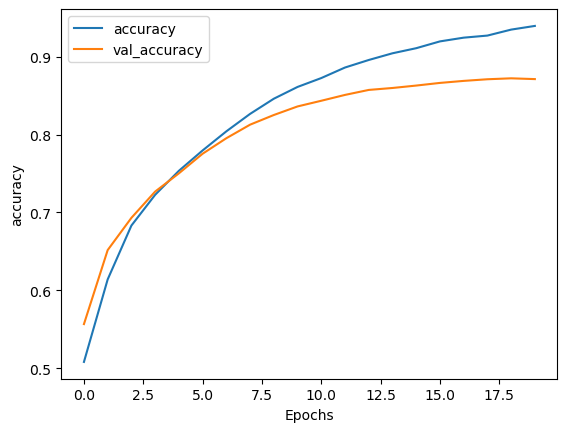

uploading part 1
upload complete (loss_plt)


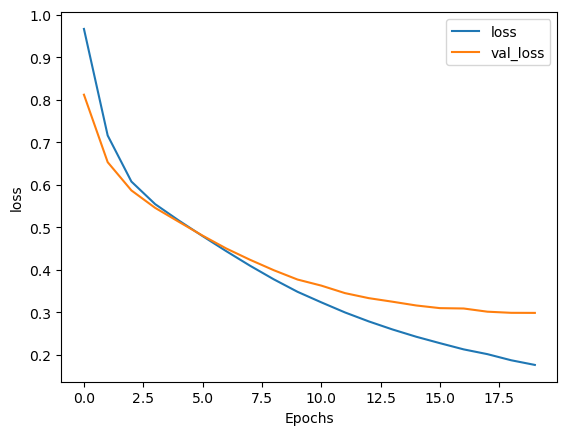

In [14]:
# plotting graphs to see variation in accuracy and loss
plot_graphs(history, 'accuracy', run, 'accuracy_plt')
plot_graphs(history, 'loss', run, 'loss_plt')


## Prediction with the model

In [15]:
sample_pred = np.array(["The new Spiderman movie is a fun watch. Loved it!"])
model.predict(sample_pred)

1/1 [==============================] - 0s 41ms/step


array([[0.89890534]], dtype=float32)

In [16]:
import pandas as pd

data = {'text': [text.decode('utf-8') for text,label in list(tfds.as_numpy(validation_data.take(250)))],
        'label': [label for text,label in list(tfds.as_numpy(validation_data.take(250)))]}
X_test = pd.DataFrame(data)

## Registering the model

In [ ]:
registered_model = client.get_or_create_registered_model(
    name="text-clf-example", labels=["nlp", "tensorflow"])

Since the model uses CustomObject (i.e KerasLayer from tensorflow_hub) we have to register the model into the catalogue using a serialized version of the model using the VertaModelBase

In [18]:
# save model locally

# Uncomment if tf saved model format
# model.save('tfhub_text.tf_saved_model', save_format='tf')

# Uncomment if h5 format
model.save('tfhub_text.h5', save_format='h5')

In [19]:
from verta.registry import VertaModelBase

class TFHubModel(VertaModelBase):
    def __init__(self, artifacts):
        import tensorflow as tf
        import tensorflow_hub as tfhub

        # custom_objects need to be defined while loading/deserializing the model
        self.model = tf.keras.models.load_model(
            artifacts["text_clf"], custom_objects={'KerasLayer': tfhub.KerasLayer})
    
    def predict(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)
        return list(self.model.predict(input_data).reshape((-1)))
    
    def batch_predict(self, df, text_column = 'text'):
        df['probs'] = self.predict(input_data=df[text_column].to_list())
        df['preds'] = [1 if x>=0.5 else 0 for x in df['probs'].to_list()]
        return df

In [20]:
# test locally

# Uncomment if tf saved model format
# artifacts = {"text_clf" : "tfhub_text.tf_saved_model/"}

# Uncomment if h5 format
artifacts = {"text_clf" : "tfhub_text.h5"}

tfhub_text_model1 = TFHubModel(artifacts)
tfhub_text_model1.predict(list(sample_pred))
# tfhub_text_model1.batch_predict(X_test.iloc[:10])

1/1 [==============================] - 0s 30ms/step


[0.89890534]

In [ ]:
# upload model to registry
from verta.environment import Python

model_version_from_cls = registered_model.create_standard_model(
    TFHubModel, 
    environment=Python(["tensorflow", "tensorflow-hub", "pandas", "numpy"]),
    name="v1", 
    artifacts=artifacts
)

## Deploy the Model to Endpoint

In [ ]:
# create endpoint and update to deploy model
tftext_endpoint = client.get_or_create_endpoint("tf-text-clf-example-v1")
tftext_endpoint.update(model_version_from_cls, wait=True)

In [29]:
# get deployed model from endpoint
deployed_model = tftext_endpoint.get_deployed_model()

*Predict* function only allows inputs that is JSON serializable thus usually lists. It doesn't accept DataFrames

In [30]:
deployed_model.predict(sample_pred)

[0.898905336856842]

*batch_predict* allows DataFrame inputs and is a better way to efficiently generate predictions for larger volumes of data compared to *predict* 

In [31]:
deployed_model.batch_predict(X_test.iloc[:250])

,text,label,probs,preds
0,I wasn't born until 4 years after this wonderf...,1,0.994849,1
1,I know nothing of the Iliad so can not comment...,0,0.010386,0
2,"David Chase's ""The Sopranos"" is perhaps the mo...",0,0.053841,0
3,I have just finished watching this film and I ...,1,0.080431,0
4,"The Sopranos stands out as an airtight, dynami...",1,0.778421,1
...,...,...,...,...
245,"I went to see Vanilla Sky with a huge, huge, h...",1,0.585024,1
246,There wasn't a day in 2002 where i wasn't chas...,1,0.267623,0
247,"""What happens when you give a homeless man $10...",0,0.108132,0
248,Soapdish may go down as one of the single most...,1,0.440066,0


In [32]:
# delete endpoint
# tftext_endpoint.delete()